## Calculate metrics including PSNR and SSIM between the input and output frames

### Definition of metrics

In [1]:
import os
import glob
import numpy as np
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image

# Brightness of reconstructed images are often different from the ground truth images. As we care more about the reconstruction quality of edges and textures, we can normalize the reconstructed images to have the same brightness as the ground truth images.
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

USE_NORMALIZE = False

def normalize(image):
    if not USE_NORMALIZE:
        return image
    min_val = np.min(image)
    max_val = np.max(image)
    normalized_image = (image - min_val) / (max_val - min_val)
    return normalized_image

Metrics for GOPR0871_11_00:
SSIM: 0.24618550817694662
PSNR: 11.318267769335169
Metrics for GOPR0396_11_00:
SSIM: 0.19233662014623673
PSNR: 10.299147601708796
Metrics for GOPR0881_11_01:
SSIM: 0.505986331038636
PSNR: 11.605049251999285
Metrics for GOPR0385_11_01:
SSIM: 0.42984117930549687
PSNR: 11.801194232350518
Metrics for GOPR0384_11_05:
SSIM: 0.28193475074450725
PSNR: 10.038754498338117
Metrics for GOPR0854_11_00:
SSIM: 0.27387127718801857
PSNR: 11.831232784977766
Metrics for GOPR0384_11_00:
SSIM: 0.39116572387092857
PSNR: 11.863237820484105
Metrics for GOPR0410_11_00:
SSIM: 0.39872604898623354
PSNR: 13.17634069095441
Metrics for GOPR0868_11_00:
SSIM: 0.23356648803370422
PSNR: 10.215478679766637
Metrics for GOPR0862_11_00:
SSIM: 0.200883301426392
PSNR: 11.167999836188393
Metrics for GOPR0869_11_00:
SSIM: 0.317537976495993
PSNR: 11.75748912594345
Average PSNR: 11.443390430475159
Average SSIM: 0.31930221530648073


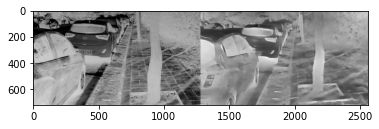

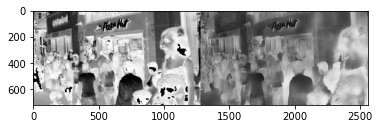

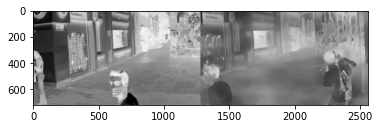

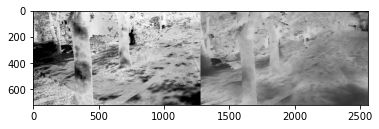

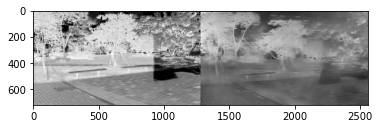

In [2]:
DATASET_DIR = "/root/autodl-tmp/datasets/GOPRO_e2vid_pred/test"
METRICS_OUTPUT_DIR = "/root/autodl-tmp/datasets/test_metrics"


def load_timestamps(path):
    with open(path, "r") as f:
        timestamps = [float(line.strip()) for line in f]
    return timestamps


def load_images(path):
    image_files = glob.glob(os.path.join(path, "*.png"))
    images = {os.path.basename(f): Image.open(f) for f in image_files}
    return images


def get_matched_period(gt_timestamps, reconstruction_timestamps):
    start_time = max(min(gt_timestamps), min(reconstruction_timestamps))
    end_time = min(max(gt_timestamps), max(reconstruction_timestamps))
    return start_time, end_time


def compare(img1, img2):
    img1 = np.array(img1)
    img2 = np.array(img2)
    img1 = normalize(img1)
    img2 = normalize(img2)
    ssim_val = ssim(img1, img2, multichannel=True, data_range=1)
    psnr_val = psnr(img1, img2, data_range=1)
    return ssim_val, psnr_val


def plot_metrics(timestamps, psnr_values, ssim_values, title, filename):
    mpl.rcParams["figure.facecolor"] = "white"

    fig, ax1 = plt.subplots(figsize=(10, 6))

    color = "tab:blue"
    ax1.set_xlabel("Timestamp (s)", fontsize=14)
    ax1.set_ylabel("PSNR", color=color, fontsize=14)
    ax1.plot(timestamps, psnr_values, color=color)
    ax1.tick_params(axis="y", labelcolor=color)
    ax1.set_ylim([0, 1.1 * max(psnr_values)])

    ax2 = ax1.twinx()

    color = "tab:red"
    ax2.set_ylabel("SSIM", color=color, fontsize=14)
    ax2.plot(timestamps, ssim_values, color=color)
    ax2.tick_params(axis="y", labelcolor=color)
    ax2.set_ylim([0, 1.1 * max(ssim_values)])

    fig.tight_layout()
    plt.title(f"{title} Over Time", fontsize=16)
    plt.grid(True)
    plt.tight_layout(pad=2)
    plt.savefig(filename)
    plt.close()


def create_parallel_image(img1, img2, filename):
    parallel_image = np.concatenate((img1, img2), axis=1)
    Image.fromarray((parallel_image * 255).astype(np.uint8)).save(filename)


def compare_images_from_subdirs(subdirs):
    total_count = 0
    total_ssim = total_psnr = 0
    metric_dirs = []

    for subdir in subdirs:
        subdir_name = os.path.basename(subdir)
        metrics_dir = os.path.join(METRICS_OUTPUT_DIR, subdir_name)
        os.makedirs(metrics_dir, exist_ok=True)
        metric_dirs.append(metrics_dir)

        gt_dir = os.path.join(subdir, "gt")
        reconstruction_dir = os.path.join(subdir, "reconstruction")

        gt_timestamps = load_timestamps(os.path.join(gt_dir, "timestamps.txt"))
        reconstruction_timestamps = load_timestamps(
            os.path.join(reconstruction_dir, "timestamps.txt")
        )

        gt_images = load_images(gt_dir)
        reconstruction_images = load_images(reconstruction_dir)

        start_time, end_time = get_matched_period(
            gt_timestamps, reconstruction_timestamps
        )

        subdir_count = 0
        subdir_ssim = subdir_psnr = 0
        matched_images = []
        psnr_values = []
        ssim_values = []
        timestamps = []
        for timestamp, gt_image in zip(gt_timestamps, sorted(gt_images.items())):
            if start_time <= timestamp <= end_time:
                for rec_timestamp, reconstruction_image in zip(
                    reconstruction_timestamps, sorted(reconstruction_images.items())
                ):
                    if abs(timestamp - rec_timestamp) < 1e-7:
                        ssim_val, psnr_val = compare(
                            gt_image[1], reconstruction_image[1]
                        )
                        subdir_ssim += ssim_val
                        subdir_psnr += psnr_val
                        subdir_count += 1
                        matched_images.append(
                            (ssim_val, gt_image[1], reconstruction_image[1])
                        )
                        ssim_values.append(ssim_val)
                        psnr_values.append(psnr_val)
                        timestamps.append(timestamp)
                        break

        if subdir_count > 0:
            total_ssim += subdir_ssim
            total_psnr += subdir_psnr
            total_count += subdir_count

            metrics_file = os.path.join(metrics_dir, "metrics.txt")
            with open(metrics_file, "w") as f:
                f.write(f"SSIM: {subdir_ssim/subdir_count}\n")
                f.write(f"PSNR: {subdir_psnr/subdir_count}\n")

            print(f"Metrics for {subdir_name}:")
            print(f"SSIM: {subdir_ssim/subdir_count}")
            print(f"PSNR: {subdir_psnr/subdir_count}")

            matched_images.sort(reverse=True)
            typical_gt, typical_rec = matched_images[0][1], matched_images[0][2]

            typical_gt.save(os.path.join(metrics_dir, "gt.png"))
            typical_rec.save(os.path.join(metrics_dir, "reconstruction.png"))

            parallel_image = os.path.join(metrics_dir, "parallel.png")
            create_parallel_image(
                np.array(typical_gt), np.array(typical_rec), parallel_image
            )

            metrics_image = os.path.join(metrics_dir, "metrics.png")
            plot_metrics(
                timestamps, psnr_values, ssim_values, subdir_name, metrics_image
            )

    if total_count > 0:
        print(f"Average PSNR: {total_psnr/total_count}")
        print(f"Average SSIM: {total_ssim/total_count}")

        metrics_file = os.path.join(METRICS_OUTPUT_DIR, "metrics.txt")
        with open(metrics_file, "w") as f:
            f.write(f"PSNR: {total_psnr/total_count}\n")
            f.write(f"SSIM: {total_ssim/total_count}\n")

        # Display 5 random parallel images
        random_dirs = random.sample(metric_dirs, min(5, len(metric_dirs)))
        for d in random_dirs:
            img = plt.imread(os.path.join(d, "parallel.png"))
            plt.imshow(img, cmap="gray")
            plt.show()
    else:
        print("No matched images found.")


if __name__ == "__main__":
    subdirs = [
        os.path.join(DATASET_DIR, d)
        for d in os.listdir(DATASET_DIR)
        if os.path.isdir(os.path.join(DATASET_DIR, d))
    ]
    compare_images_from_subdirs(subdirs)